# CIFAR-10 on modified LeNet-5 CNN architecture using PyTorch

In [4]:
import sys
sys.version

'3.9.13 (main, Aug 25 2022, 23:51:50) [MSC v.1916 64 bit (AMD64)]'

# Import Libraries

In [5]:
import torch 
import torch.nn as nn 
import torch.nn.functional as F 
import torchvision.transforms as transforms 
import torchvision
import torch.optim as optim
import matplotlib.style as style
import numpy as np
import matplotlib.pyplot as plt 
import pickle 
import warnings 
import time 
from torch.autograd import Variable
warnings.filterwarnings('ignore')

# Initialize Hyper-parameters

In [6]:
batch_size = 4
learning_rate = 0.0001
epoch_range = 15
weight_decay = 0
dropout = True
xavier = False

trainLoss = []
testLoss = []
trainAccuracy = []
trainEpoch = []
testAccuracy = []

# Download CIFAR-10 dataset

In [7]:
transform_cifar = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))])

traindataset= torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform_cifar)
train_set = torch.utils.data.DataLoader(traindataset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testdataset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform_cifar)
test_set = torch.utils.data.DataLoader(testdataset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

labels = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


# Convolution Neural Network Model Structure

In [8]:
class modelCIFAR(nn.Module):
    def __init__(self):
        super(modelCIFAR, self).__init__()
        #initially 32*32 pixel size
        self.convLayer1 = nn.Conv2d(3, 32, 5)             # First conv layer (3(input), 32(output), 5(filter_size))
        self.maxPool = nn.MaxPool2d(2, 2)                 # Max Pool (2(filter_size), 2(stride))
        self.convLayer2 = nn.Conv2d(32, 64, 5)            # Second conv layer (32(input), 64(output), 5(filter_size))
        self.drop1 = nn.Dropout(0.2, inplace=False)       # Dropout layer with probability 0.2 
        self.fullyc1 = nn.Linear(1600, 200)               # Fully Connected Layer (64*5*5(input), 200(output))
        self.xav = nn.init.xavier_normal_(self.fullyc1.weight)
        self.fullyc2 = nn.Linear(200, 100)                # Fully Connected Layer (200(input), 100(output))
        self.fullyc3 = nn.Linear(100, 10)                 # Fully Connected Layer (100(input), 10(output))
        

    def forward(self, img):
        img = self.maxPool(self.drop1(F.relu(self.convLayer1(img))))
        img = self.maxPool(self.drop1(F.relu(self.convLayer2(img))))
        # img = self.maxPool(F.relu(self.convLayer1(img)))
        # img = self.maxPool(F.relu(self.convLayer2(img)))
        img = img.view(-1, 64 * 5 * 5)
        img = F.relu(self.fullyc1(img))
        img = F.relu(self.fullyc2(img))
        img = self.fullyc3(img)
        return img   

# Instantiate the model

In [9]:
cifar = modelCIFAR()

# Enable GPU

In [10]:
use_cuda = True
if use_cuda and torch.cuda.is_available():
  cifar.cuda()

# Loss Function and Optimizer

In [11]:
optimizer_dict = {'SGD': optim.SGD(cifar.parameters(), lr=learning_rate, momentum=0.9)}
criterion = nn.CrossEntropyLoss()

# Training the CNN model

In [12]:
def train_CIFAR():
    for epoch in range(epoch_range): 
        runningLoss = 0.0
        trAcc = 0.0
        totTrain = 0
        start_time = time.time()
        for i, data in enumerate(train_set, 0):
            inputTrain, labelTrain = data
            inputTrain = Variable(inputTrain)
            labelTrain = Variable(labelTrain)

            if use_cuda and torch.cuda.is_available():
              inputTrain = inputTrain.cuda()
              labelTrain = labelTrain.cuda()


            optimizer.zero_grad()
            outputTrain = cifar(inputTrain)
            loss = criterion(outputTrain, labelTrain)
            loss.backward()
            optimizer.step()

            runningLoss += loss.item()
            trainEpoch.append(loss.item())

            totTrain += 1  
            _, pred = torch.max(outputTrain, dim=1)
            correct_train = pred.eq(labelTrain.data.view_as(pred))
            accuracy_train = torch.mean(correct_train.type(torch.FloatTensor))
            trAcc += accuracy_train.item()


        with torch.no_grad():
            corr, test_l = test_CIFAR_1(cifar, test_set)

        trainLoss.append(runningLoss/totTrain)
        testLoss.append(test_l/len(testdataset))
        trainAccuracy.append(trAcc/totTrain)
        testAccuracy.append(corr/len(testdataset))

        print("Epoch: {}/{} |".format(epoch+1, epoch_range), 
              "Train loss: %.3f |" % (runningLoss/totTrain),
              "Train Accuracy: %.3f |" % (100*trAcc/totTrain),
              "Test loss: %.3f |" % (test_l/len(testdataset)),
              "Test Accuracy: %.3f |" % (100*corr/len(testdataset)),
              "Time/Epoch: %.3f sec|" % (time.time() - start_time))

        runningLoss = 0.0
        trAcc = 0.0
    print('Finished Training')
    print_CIFAR(trainAccuracy, testAccuracy, trainLoss, testLoss, key, trainEpoch)

# Testing the CNN model

In [13]:
def test_CIFAR_1(cifar, test_set):
    correcTest = 0
    testLoss = 0.0
    for data in test_set:
        imageTest, labelTest = data

        if use_cuda and torch.cuda.is_available():
          imageTest = imageTest.cuda()
          labelTest = labelTest.cuda()

        outputTest = cifar(imageTest)
        testLoss += criterion(outputTest, labelTest).item()

        _, predicted_test = torch.max(outputTest.data, 1)
        correcTest += (predicted_test == labelTest).sum().item()


    return correcTest, testLoss

# Plotting the CNN performance

In [14]:
def mean(li): return sum(li)/len(li)

def print_CIFAR(trainAccuracy, testAccuracy, trainLoss, testLoss, key, trainEpoch):
    plt.figure(1, figsize=(10,6))
    plt.plot(trainAccuracy, label='Train Accuracy', color='red', marker='o', linewidth=2)
    plt.plot(testAccuracy, label='Test Accuracy', color='blue', marker='x', linewidth=2)
    plt.xlabel("epochs")
    plt.ylabel("accuracy")
    plt.title("Epoch Accuracy Plot \n Dropout: "+str(dropout)+"| Learning Rate: "+str(learning_rate)+"| Optimizers: "+key+
              " | Weight Decay:"+str(weight_decay)+"| Batch Size: "+str(batch_size)+"| Filter Weight(xavier_normal): "+str(xavier))
    plt.legend()
    plt.savefig('acc'+'_'+str(learning_rate)+'_'+key+'_'+str(weight_decay)+'_'+str(batch_size)+'_'+str(xavier)+'.jpg', dpi=100, bbox_inches='tight')

    plt.figure(2, figsize=(10,6))
    plt.plot(trainLoss, label='Train loss', color='r', marker='o', linewidth=2)
    plt.plot(testLoss, label='Test loss', color='b', marker='x', linewidth=2)
    plt.xlabel("epochs")
    plt.ylabel("loss")
    # plt.title("Loss plots")
    plt.title("Epoch Loss Plot \n Dropout: "+str(dropout)+"| Learning Rate: "+str(learning_rate)+"| Optimizers: "+key+
              " | Weight Decay: "+str(weight_decay)+"| Batch Size: "+str(batch_size)+"| Filter Weight(xavier_normal): "+str(xavier))
    plt.legend()
    plt.savefig('loss'+'_'+str(learning_rate)+'_'+key+'_'+str(weight_decay)+'_'+str(batch_size)+'_'+str(xavier)+'.jpg', dpi=100, bbox_inches='tight')
    
    plt.figure(3, figsize=(12,4))
    plt.plot([mean(trainEpoch[i:i+500]) for i in range(len(trainEpoch)-50)])
    plt.xlabel('training batch-size')
    plt.ylabel('loss')
    plt.title("Performance Curve \n Dropout: "+str(dropout)+"| Learning Rate: "+str(learning_rate)+"| Optimizers: "+key+
              " | Weight Decay: "+str(weight_decay)+"| Batch Size: "+str(batch_size)+"| Filter Weight(xavier_normal): "+str(xavier))
    plt.savefig('per'+'_'+str(learning_rate)+'_'+key+'_'+str(weight_decay)+'_'+str(batch_size)+'_'+str(xavier)+'.jpg',dpi=100, bbox_inches='tight')
    
    # plt.show()

# Running the Final model

Epoch: 1/15 | Train loss: 1.953 | Train Accuracy: 28.446 | Test loss: 0.412 | Test Accuracy: 39.720 | Time/Epoch: 78.125 sec|
Epoch: 2/15 | Train loss: 1.530 | Train Accuracy: 44.334 | Test loss: 0.363 | Test Accuracy: 47.960 | Time/Epoch: 77.842 sec|
Epoch: 3/15 | Train loss: 1.372 | Train Accuracy: 50.396 | Test loss: 0.329 | Test Accuracy: 52.020 | Time/Epoch: 77.992 sec|
Epoch: 4/15 | Train loss: 1.254 | Train Accuracy: 54.944 | Test loss: 0.307 | Test Accuracy: 56.420 | Time/Epoch: 80.966 sec|
Epoch: 5/15 | Train loss: 1.154 | Train Accuracy: 59.030 | Test loss: 0.282 | Test Accuracy: 59.350 | Time/Epoch: 80.457 sec|
Epoch: 6/15 | Train loss: 1.066 | Train Accuracy: 62.244 | Test loss: 0.266 | Test Accuracy: 62.390 | Time/Epoch: 76.533 sec|
Epoch: 7/15 | Train loss: 0.996 | Train Accuracy: 64.654 | Test loss: 0.251 | Test Accuracy: 64.780 | Time/Epoch: 76.457 sec|
Epoch: 8/15 | Train loss: 0.935 | Train Accuracy: 67.070 | Test loss: 0.247 | Test Accuracy: 65.270 | Time/Epoch: 79.4

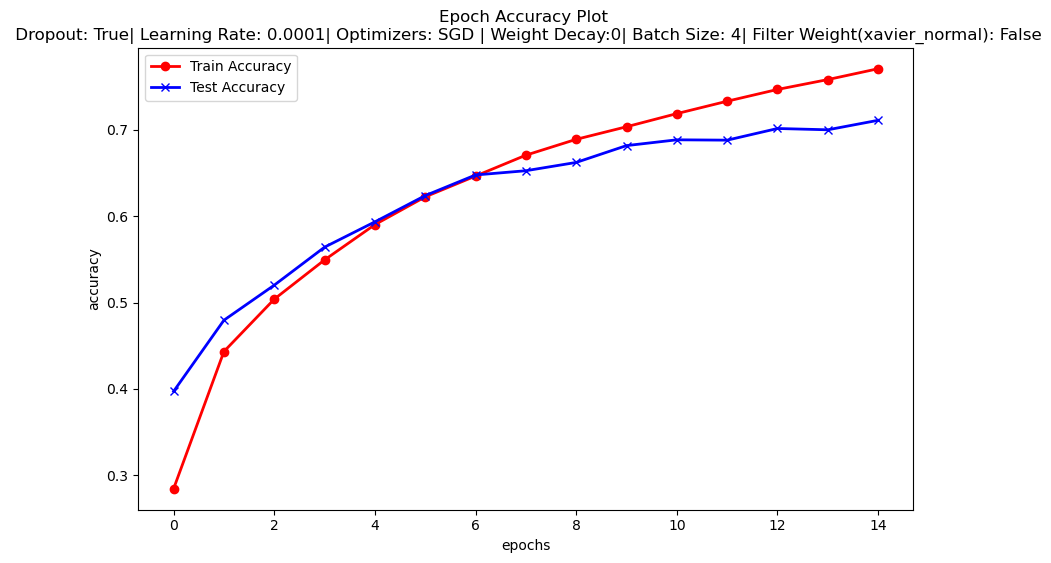

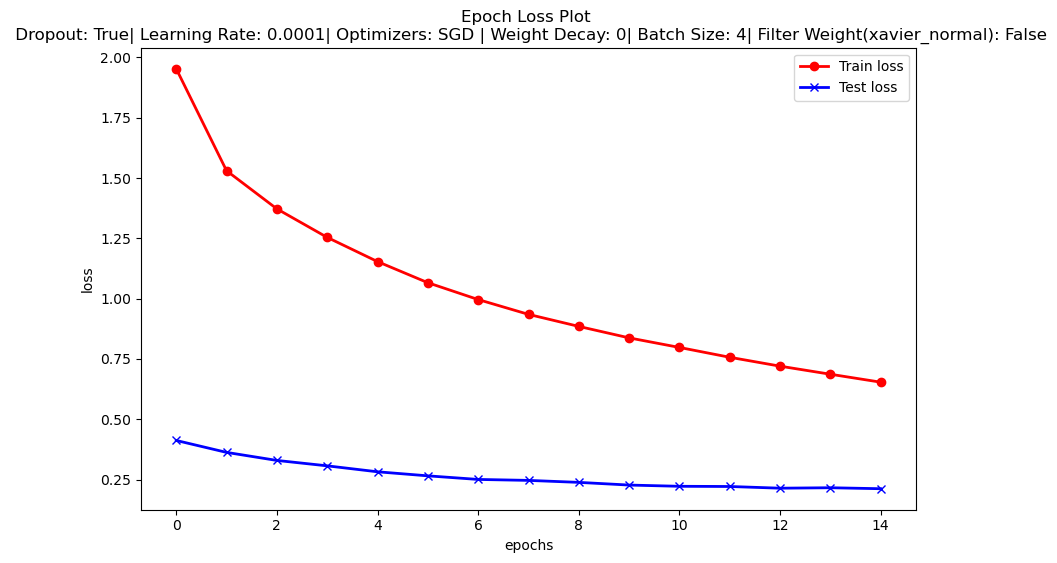

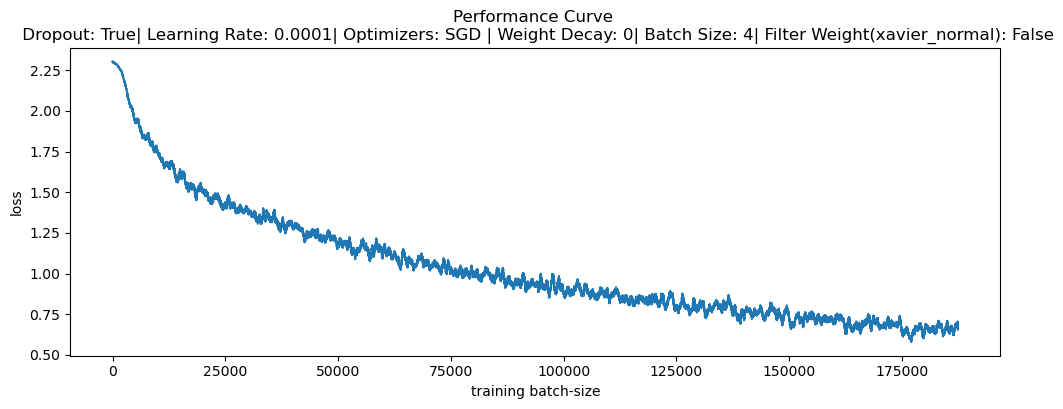

In [15]:
for key,value in optimizer_dict.items():
    optimizer = value;
    train_CIFAR()

In [16]:
PATH = './cifar_net'+'_'+str(learning_rate)+'_'+key+'_'+str(weight_decay)+'_'+str(batch_size)+'_'+str(xavier)+'.pth'
torch.save(cifar.state_dict(), PATH)